In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns
import pytorch_lightning as pl
from tqdm.notebook import tqdm
np.random.seed(123)

In [2]:
# read csv and parse date-times into Pandas Timestamp object
X_data = pd.read_csv('ratings.csv', parse_dates=['timestamp'])

/var/folders/t4/fg4c270s6mb6t8z6cg5ct78c0000gn/T/ipykernel_1454/133746022.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  X_data = pd.read_csv('ratings.csv', parse_dates=['timestamp'])


In [3]:
# we have approximately 26 million of rating data
X_data.shape

(26024289, 4)

# Preprocessing

In [4]:
# count unique user ids, there are 270896 of them
user_counts = X_data['userId'].value_counts() 

We have a very huge amount of data (total of 26 million rows). We might want to get rid of those that do not give us a lot information. For example, let's see how many of the users have given less than only 20 ratings in total

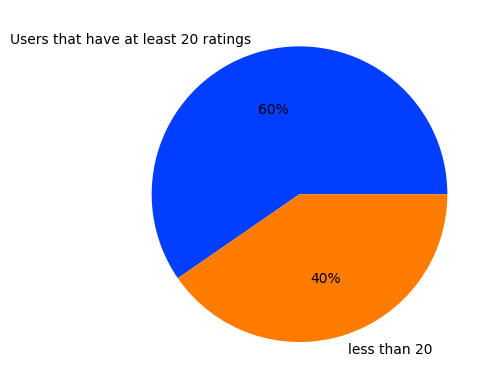

In [5]:
# let's see the percentage of those in a pie chart
user_counts_py = user_counts.values
count_bigger = np.count_nonzero(user_counts_py > 20)
count_smaller = len(user_counts_py) - count_bigger
ls = []
ls.append(count_bigger)
ls.append(count_smaller)

palette_color = sns.color_palette('bright')
plt.pie(ls, labels=['Users that have at least 20 ratings', 'less than 20'], colors=palette_color, autopct='%.0f%%')
plt.show()

Get rid of the users that gave more than 20 ratings in total. By doing this, we


*   decrease the training time
*   reduce memory requirements
*   reduce noise

In return, we may lose some information. But even without those users we still have 161497 unique users





In [6]:
# ids of users with > 20 occurences i.e. > 20 ratings, there are 161497 of them
user_ids = user_counts[user_counts > 20].index.tolist() 
# create a new dataframe to use in the future and keep the original one unchanged
# this new dataframe only has the users that gave more than 20 ratings
new_X_data = pd.DataFrame({'userId': user_ids, 'count': user_counts[user_counts > 20]})
print(new_X_data.shape)

(161497, 2)


Among the data that we now have at our hands, we will randomly choose %5 of them. This again comes with advantages and disadvantages, but in the end we will be left with around 8000 unique users and a total of over than 1.2 millions of data, which we think is a still significant amount of data


In [7]:
np.random.seed(123) # necessary for consistent results
# randomly select % 5 of the users to simplify our data
rand_userIds = np.random.choice(new_X_data['userId'].unique(), size=int(len(new_X_data['userId'].unique())*0.05),replace=False)
# only get the rows of the selected users from the original data,
# i.e. combine the selected user ids with the rest of the information: movieId, rating, timestamp
new_X_data = X_data.loc[X_data['userId'].isin(rand_userIds)]

print('There are {} rows of data from {} users'.format(len(new_X_data), len(rand_userIds)))
print(new_X_data.shape)

There are 1250005 rows of data from 8074 users
(1250005, 4)


In [8]:
# let's see our new data
new_X_data.head()

,userId,movieId,rating,timestamp
204,8,1,4.0,1013443596
205,8,7,2.0,1013442976
206,8,44,3.0,1013442518
207,8,47,4.0,1013443770
208,8,170,3.0,1013442544


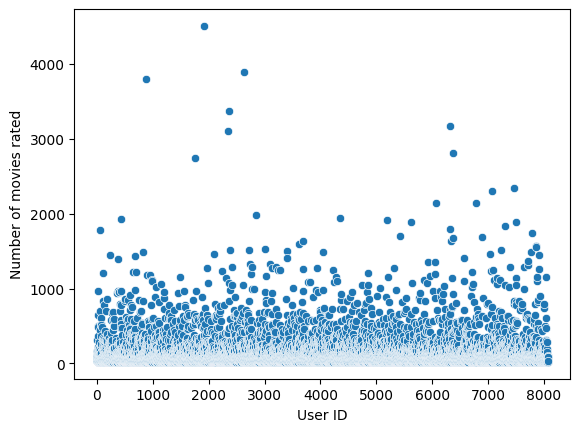

In [9]:
# let's plot the ratings given by the users to have a general idea of the image
# we will see that vast majority of users gave less than ~700 ratings in total
movie_counts = new_X_data['userId'].value_counts(sort=False)
my_array = np.arange(len(rand_userIds))
zort_df = pd.DataFrame({'User ID': my_array,
                       'Number of movies rated': movie_counts})
sns.scatterplot(data=zort_df, x="User ID", y="Number of movies rated")
plt.show()

# Train - Validation - Test split

In [10]:
# ignore warnings
import warnings
warnings.filterwarnings('ignore')

The most recent review for each user will serve as the test set (i.e., one is left out), the second most recent will serve as the validation set, and the remaining ratings will serve as training set

In [11]:
# rank the timestamps of ratings for each user, put them in a new column 'rank_latest'
# most recent review of that user will have the highest ranking, least recent will have the lowest
new_X_data['rank_latest'] = new_X_data.groupby(['userId'])['timestamp'].rank(method='first', ascending=False)

In [12]:
# let's see first 3 rows as an example
new_X_data.head(3)

,userId,movieId,rating,timestamp,rank_latest
204,8,1,4.0,1013443596,46.0
205,8,7,2.0,1013442976,72.0
206,8,44,3.0,1013442518,105.0


In [13]:
test_ratings = new_X_data[new_X_data['rank_latest'] == 1]
valid_ratings = new_X_data[new_X_data['rank_latest'] == 2]
train_ratings = new_X_data[new_X_data['rank_latest'] > 2]

In [14]:
print(train_ratings.shape) # around 1.2 mil data used for training
print(valid_ratings.shape) # around 8000 data used for valdiation
print(test_ratings.shape) # arounda 8000 data used for test
# these may change later

(1233857, 5)
(8074, 5)
(8074, 5)


In [15]:
# drop 'rank_latest' column
train_ratings = train_ratings[['userId', 'movieId', 'rating']]
valid_ratings = valid_ratings[['userId', 'movieId', 'rating']]
test_ratings = test_ratings[['userId', 'movieId', 'rating']]

In [16]:
# save them into csv files
train_ratings.to_csv('new_train_ratings.csv', index=False)
valid_ratings.to_csv('new_valid_ratings.csv', index=False)
test_ratings.to_csv('new_test_ratings.csv', index=False)

In [17]:
# see train data for example
train_ratings.head(5)

,userId,movieId,rating
204,8,1,4.0
205,8,7,2.0
206,8,44,3.0
207,8,47,4.0
208,8,170,3.0


## Explicit Trial

In [18]:
num_users = new_X_data['userId'].max()+1
num_items = new_X_data['movieId'].max()+1
all_movie_IDs = new_X_data['movieId'].unique()
print(num_users)
print(all_movie_IDs.shape)

270817
(20875,)


# With Lightning Explicit

In [19]:
import torch
from torch.utils.data import Dataset

class RatingDataset(Dataset):

    # ratings: ratings data (train_ratings for training)
    # all_movie_IDs: all unique movieIDs
    def __init__(self, ratings):
        self.users, self.items, self.labels = torch.tensor(ratings["userId"].values), torch.tensor(ratings["movieId"].values), torch.tensor(ratings["rating"].values)

    # get length
    def __len__(self):
        return len(self.users)
  
    # get single instance
    def __getitem__(self, idx):
        return self.users[idx], self.items[idx], self.labels[idx]



In [20]:
losses = []

In [21]:
from torch.utils.data import DataLoader

class ModelWithLightningDOT(pl.LightningModule):

    def __init__(self, num_users, num_items, ratings, all_movie_IDs, embd_dimension, layers, lr, batch):
        super().__init__()
        self.layers = layers
        self.lr = lr
        self.batch_size = batch
        self.user_embedding = nn.Embedding(num_embeddings=num_users, embedding_dim=embd_dimension)
        self.item_embedding = nn.Embedding(num_embeddings=num_items, embedding_dim=embd_dimension)
        if layers == 2:
            self.dense1 = nn.Linear(in_features=16, out_features=64)
            self.dense2 = nn.Linear(in_features=64, out_features=32)
            self.output = nn.Linear(in_features=32, out_features=1)
        elif layers == 3:
            self.dense1 = nn.Linear(in_features=16, out_features=64)
            self.dense2 = nn.Linear(in_features=64, out_features=32)
            self.dense3 = nn.Linear(in_features=32, out_features=16)
            self.output = nn.Linear(in_features=16, out_features=1)
        
        self.training_step_outputs = []
        self.ratings = ratings
        self.all_movie_IDs = all_movie_IDs

    def forward(self, user_input, item_input):
        user_embedded = self.user_embedding(user_input)
        item_embedded = self.item_embedding(item_input)

        tensor = torch.cat([user_embedded, item_embedded], dim=-1)

        tensor = nn.ReLU()(self.dense1(tensor))
        tensor = nn.ReLU()(self.dense2(tensor))
        if self.layers == 3:
            tensor = nn.ReLU()(self.dense3(tensor))
        
        pred = nn.Sigmoid()(self.output(tensor))
        pred = (pred * 4) + 1  # Scale the predictions to the range [1, 5]

        return pred
    
    def training_step(self, batch, batch_idx):
        user_input, item_input, labels = batch
        predicted_labels = self(user_input, item_input)
        loss = nn.MSELoss()(predicted_labels, labels.view(-1, 1).float())
        self.training_step_outputs.append(loss)
        return loss

    def on_train_epoch_end(self):
        all_preds = torch.stack(self.training_step_outputs)
        avg_loss = all_preds.mean()
        self.log('avg_train_loss', avg_loss)  # Log the average loss for the epoch
        losses.append(avg_loss.item())
        print(f"Epoch: {self.current_epoch+1}/{self.trainer.max_epochs}, Loss: {avg_loss.item()}")

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.lr)

    def train_dataloader(self):
        return DataLoader(RatingDataset(self.ratings),
                          batch_size=self.batch_size, num_workers=0)


In [22]:
num_users = new_X_data['userId'].max() + 1
num_items = new_X_data['movieId'].max() + 1
all_movie_IDs = new_X_data['movieId'].unique()
embd_dimension = 8

# Hyperparameters to be tuned
hyperparams = {
    "layers" : [2, 3],
    "batch_sizes" : [256, 512],
    "alphas" : [0.001, 0.01, 0.1]
}

all_models = []
for layer in hyperparams["layers"]:
    for batch_size in hyperparams["batch_sizes"]:
        for alpha in hyperparams["alphas"]:
            print(f"Model with layers: {'[16, 64]' if layer == 2 else '[16, 64, 32]'}, batch_size: {batch_size}, lr: {alpha}")
            model_lightning = ModelWithLightningDOT(num_users, num_items, train_ratings, all_movie_IDs, embd_dimension, layer, alpha, batch_size)
            trainer = pl.Trainer(accelerator='cpu', max_epochs=15, logger=False)
            trainer.fit(model_lightning)
            all_models.append(model_lightning)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Model with layers: [16, 64], batch_size: 256, lr: 0.001



  | Name           | Type      | Params
---------------------------------------------
0 | user_embedding | Embedding | 2.2 M 
1 | item_embedding | Embedding | 1.4 M 
2 | dense1         | Linear    | 1.1 K 
3 | dense2         | Linear    | 2.1 K 
4 | output         | Linear    | 33    
---------------------------------------------
3.6 M     Trainable params
0         Non-trainable params
3.6 M     Total params
14.320    Total estimated model params size (MB)


Epoch 14: 100%|██████████| 4820/4820 [00:48<00:00, 99.97it/s] Epoch: 15/15, Loss: 0.8711662292480469


`Trainer.fit` stopped: `max_epochs=15` reached.


Epoch 14: 100%|██████████| 4820/4820 [00:48<00:00, 99.73it/s]
Model with layers: [16, 64], batch_size: 256, lr: 0.01


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name           | Type      | Params
---------------------------------------------
0 | user_embedding | Embedding | 2.2 M 
1 | item_embedding | Embedding | 1.4 M 
2 | dense1         | Linear    | 1.1 K 
3 | dense2         | Linear    | 2.1 K 
4 | output         | Linear    | 33    
---------------------------------------------
3.6 M     Trainable params
0         Non-trainable params
3.6 M     Total params
14.320    Total estimated model params size (MB)


Epoch 14: 100%|██████████| 4820/4820 [00:56<00:00, 85.51it/s]Epoch: 15/15, Loss: 0.8166090250015259


`Trainer.fit` stopped: `max_epochs=15` reached.


Epoch 14: 100%|██████████| 4820/4820 [00:56<00:00, 85.20it/s]

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name           | Type      | Params
---------------------------------------------
0 | user_embedding | Embedding | 2.2 M 
1 | item_embedding | Embedding | 1.4 M 
2 | dense1         | Linear    | 1.1 K 
3 | dense2         | Linear    | 2.1 K 
4 | output         | Linear    | 33    
---------------------------------------------
3.6 M     Trainable params
0         Non-trainable params
3.6 M     Total params
14.320    Total estimated model params size (MB)



Model with layers: [16, 64], batch_size: 256, lr: 0.1
Epoch 14: 100%|██████████| 4820/4820 [00:55<00:00, 86.96it/s]Epoch: 15/15, Loss: 1.1629210710525513


`Trainer.fit` stopped: `max_epochs=15` reached.


Epoch 14: 100%|██████████| 4820/4820 [00:55<00:00, 86.58it/s]

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name           | Type      | Params
---------------------------------------------
0 | user_embedding | Embedding | 2.2 M 
1 | item_embedding | Embedding | 1.4 M 
2 | dense1         | Linear    | 1.1 K 
3 | dense2         | Linear    | 2.1 K 
4 | output         | Linear    | 33    
---------------------------------------------
3.6 M     Trainable params
0         Non-trainable params
3.6 M     Total params
14.320    Total estimated model params size (MB)



Model with layers: [16, 64], batch_size: 512, lr: 0.001
Epoch 14: 100%|██████████| 2410/2410 [00:34<00:00, 69.84it/s]Epoch: 15/15, Loss: 0.8771356344223022


`Trainer.fit` stopped: `max_epochs=15` reached.


Epoch 14: 100%|██████████| 2410/2410 [00:34<00:00, 69.53it/s]
Model with layers: [16, 64], batch_size: 512, lr: 0.01


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name           | Type      | Params
---------------------------------------------
0 | user_embedding | Embedding | 2.2 M 
1 | item_embedding | Embedding | 1.4 M 
2 | dense1         | Linear    | 1.1 K 
3 | dense2         | Linear    | 2.1 K 
4 | output         | Linear    | 33    
---------------------------------------------
3.6 M     Trainable params
0         Non-trainable params
3.6 M     Total params
14.320    Total estimated model params size (MB)


Epoch 14: 100%|██████████| 2410/2410 [00:38<00:00, 62.77it/s]Epoch: 15/15, Loss: 0.799494206905365


`Trainer.fit` stopped: `max_epochs=15` reached.


Epoch 14: 100%|██████████| 2410/2410 [00:38<00:00, 62.51it/s]
Model with layers: [16, 64], batch_size: 512, lr: 0.1


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name           | Type      | Params
---------------------------------------------
0 | user_embedding | Embedding | 2.2 M 
1 | item_embedding | Embedding | 1.4 M 
2 | dense1         | Linear    | 1.1 K 
3 | dense2         | Linear    | 2.1 K 
4 | output         | Linear    | 33    
---------------------------------------------
3.6 M     Trainable params
0         Non-trainable params
3.6 M     Total params
14.320    Total estimated model params size (MB)


Epoch 14: 100%|██████████| 2410/2410 [00:32<00:00, 74.24it/s]

`Trainer.fit` stopped: `max_epochs=15` reached.


Epoch: 15/15, Loss: 1.1493399143218994
Epoch 14: 100%|██████████| 2410/2410 [00:32<00:00, 73.55it/s]

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name           | Type      | Params
---------------------------------------------
0 | user_embedding | Embedding | 2.2 M 
1 | item_embedding | Embedding | 1.4 M 
2 | dense1         | Linear    | 1.1 K 
3 | dense2         | Linear    | 2.1 K 
4 | dense3         | Linear    | 528   
5 | output         | Linear    | 17    
---------------------------------------------
3.6 M     Trainable params
0         Non-trainable params
3.6 M     Total params
14.322    Total estimated model params size (MB)



Model with layers: [16, 64, 32], batch_size: 256, lr: 0.001
Epoch 14: 100%|██████████| 4820/4820 [00:58<00:00, 82.11it/s]Epoch: 15/15, Loss: 0.864414632320404


`Trainer.fit` stopped: `max_epochs=15` reached.


Epoch 14: 100%|██████████| 4820/4820 [00:58<00:00, 81.79it/s]

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name           | Type      | Params
---------------------------------------------
0 | user_embedding | Embedding | 2.2 M 
1 | item_embedding | Embedding | 1.4 M 
2 | dense1         | Linear    | 1.1 K 
3 | dense2         | Linear    | 2.1 K 
4 | dense3         | Linear    | 528   
5 | output         | Linear    | 17    
---------------------------------------------
3.6 M     Trainable params
0         Non-trainable params
3.6 M     Total params
14.322    Total estimated model params size (MB)



Model with layers: [16, 64, 32], batch_size: 256, lr: 0.01
Epoch 14: 100%|██████████| 4820/4820 [01:05<00:00, 73.11it/s]

`Trainer.fit` stopped: `max_epochs=15` reached.


Epoch: 15/15, Loss: 0.8171711564064026
Epoch 14: 100%|██████████| 4820/4820 [01:06<00:00, 72.77it/s]

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name           | Type      | Params
---------------------------------------------
0 | user_embedding | Embedding | 2.2 M 
1 | item_embedding | Embedding | 1.4 M 
2 | dense1         | Linear    | 1.1 K 
3 | dense2         | Linear    | 2.1 K 
4 | dense3         | Linear    | 528   
5 | output         | Linear    | 17    
---------------------------------------------
3.6 M     Trainable params
0         Non-trainable params
3.6 M     Total params
14.322    Total estimated model params size (MB)



Model with layers: [16, 64, 32], batch_size: 256, lr: 0.1
Epoch 14: 100%|██████████| 4820/4820 [01:03<00:00, 75.40it/s]

`Trainer.fit` stopped: `max_epochs=15` reached.


Epoch: 15/15, Loss: 1.1628360748291016
Epoch 14: 100%|██████████| 4820/4820 [01:04<00:00, 75.08it/s]

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name           | Type      | Params
---------------------------------------------
0 | user_embedding | Embedding | 2.2 M 
1 | item_embedding | Embedding | 1.4 M 
2 | dense1         | Linear    | 1.1 K 
3 | dense2         | Linear    | 2.1 K 
4 | dense3         | Linear    | 528   
5 | output         | Linear    | 17    
---------------------------------------------
3.6 M     Trainable params
0         Non-trainable params
3.6 M     Total params
14.322    Total estimated model params size (MB)



Model with layers: [16, 64, 32], batch_size: 512, lr: 0.001
Epoch 14: 100%|██████████| 2410/2410 [00:43<00:00, 55.64it/s]Epoch: 15/15, Loss: 0.8895935416221619


`Trainer.fit` stopped: `max_epochs=15` reached.


Epoch 14: 100%|██████████| 2410/2410 [00:43<00:00, 55.46it/s]
Model with layers: [16, 64, 32], batch_size: 512, lr: 0.01


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name           | Type      | Params
---------------------------------------------
0 | user_embedding | Embedding | 2.2 M 
1 | item_embedding | Embedding | 1.4 M 
2 | dense1         | Linear    | 1.1 K 
3 | dense2         | Linear    | 2.1 K 
4 | dense3         | Linear    | 528   
5 | output         | Linear    | 17    
---------------------------------------------
3.6 M     Trainable params
0         Non-trainable params
3.6 M     Total params
14.322    Total estimated model params size (MB)


Epoch 14: 100%|██████████| 2410/2410 [00:30<00:00, 78.62it/s]Epoch: 15/15, Loss: 0.791500985622406


`Trainer.fit` stopped: `max_epochs=15` reached.


Epoch 14: 100%|██████████| 2410/2410 [00:30<00:00, 78.24it/s]
Model with layers: [16, 64, 32], batch_size: 512, lr: 0.1


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name           | Type      | Params
---------------------------------------------
0 | user_embedding | Embedding | 2.2 M 
1 | item_embedding | Embedding | 1.4 M 
2 | dense1         | Linear    | 1.1 K 
3 | dense2         | Linear    | 2.1 K 
4 | dense3         | Linear    | 528   
5 | output         | Linear    | 17    
---------------------------------------------
3.6 M     Trainable params
0         Non-trainable params
3.6 M     Total params
14.322    Total estimated model params size (MB)


Epoch 14: 100%|██████████| 2410/2410 [00:34<00:00, 70.50it/s]Epoch: 15/15, Loss: 1.1491265296936035


`Trainer.fit` stopped: `max_epochs=15` reached.


Epoch 14: 100%|██████████| 2410/2410 [00:34<00:00, 70.04it/s]


Evaluate all of them on validation set

In [23]:
from sklearn.metrics import mean_absolute_error

In [24]:
alpha_idx = -1
users = torch.tensor(valid_ratings['userId'].values)
items = torch.tensor(valid_ratings['movieId'].values)
ratings = torch.tensor(valid_ratings['rating'].values)

for i in range(0, len(all_models)):
    alpha_idx += 1
    print(f"Model with layers: {'[16, 64]' if i < 6 else '[16, 64, 32]'}, ", end="")
    print(f"batch_size: {hyperparams['batch_sizes'][0 if i < 3 or (i >= 6 and i <= 8) else 1]}, ", end="")
    print(f"learning_rate: {hyperparams['alphas'][alpha_idx]}: ", end="")
    if (i+1) % 3 == 0: alpha_idx = -1
    predicted_labels = all_models[i](users, items)
    predictions = predicted_labels.detach().numpy()
# Convert to nearest 0.5 interval
    rounded_pred = np.round(predictions * 2) / 2
    error = mean_absolute_error(test_ratings['rating'], rounded_pred)
    print("MAE error is: ", error)


Model with layers: [16, 64], batch_size: 256, learning_rate: 0.001: MAE error is:  0.8319296507307407
Model with layers: [16, 64], batch_size: 256, learning_rate: 0.01: MAE error is:  0.886177854842705
Model with layers: [16, 64], batch_size: 256, learning_rate: 0.1: MAE error is:  0.8910081743869209
Model with layers: [16, 64], batch_size: 512, learning_rate: 0.001: MAE error is:  0.815518949715135
Model with layers: [16, 64], batch_size: 512, learning_rate: 0.01: MAE error is:  0.852365618033193
Model with layers: [16, 64], batch_size: 512, learning_rate: 0.1: MAE error is:  0.8910081743869209
Model with layers: [16, 64, 32], batch_size: 256, learning_rate: 0.001: MAE error is:  0.8081496160515234
Model with layers: [16, 64, 32], batch_size: 256, learning_rate: 0.01: MAE error is:  0.8098835769135496
Model with layers: [16, 64, 32], batch_size: 256, learning_rate: 0.1: MAE error is:  0.8910081743869209
Model with layers: [16, 64, 32], batch_size: 512, learning_rate: 0.001: MAE error 

BEST MODEL: 
Model with layers: [16, 64, 32], batch_size: 256, learning_rate: 0.001: MAE error is:  0.8081496160515234 (Due to memory purposes, we could not train 35 epochs which is the epoch number for training)


Train the best model on train + validation data, and test it on test data fo final results

In [28]:
new_train_ratings = pd.concat([train_ratings, valid_ratings])
num_users = new_X_data['userId'].max()+1
num_items = new_X_data['movieId'].max()+1
all_movie_IDs = new_X_data['movieId'].unique()
embd_dimension = 8

In [ ]:
losses.clear()
layer = 3
alpha = 0.001
batch_size = 256
num_epochs = 35##This much epoch for final model
best_model = ModelWithLightningDOT(num_users, num_items, new_train_ratings, all_movie_IDs, embd_dimension, layer, alpha, batch_size)
trainer = pl.Trainer(accelerator='cpu', max_epochs=num_epochs, logger=False)
trainer.fit(best_model)

In [ ]:
numbers = []
for i in range(1, 16):
    numbers.append(i)

plt.plot(numbers, losses, 'r', label='Training loss')
#plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training loss wrt EPOCH for Best Model')
plt.legend(loc=0)
plt.figure()
plt.show()

Evaluate the best model

In [ ]:
predicted_labels = best_model(users, items)
predictions = predicted_labels.detach().numpy()
rounded_pred = np.round(predictions * 2) / 2
error = mean_absolute_error(test_ratings['rating'], rounded_pred)
print("MAE error is: ", error)